# CardNet: A Convolutional Neural Network for Playing Card Classification

### Authors: David Riva & Nathan Orwick

## Introduction

Our project aims to address the classification of playing cards: a fundamental aspect of various card games, such as poker. The primary goal is to develop a robust classifier capable of accurately identifying individual playing cards from images.

This project has two interesting real world applications:
1. Enhancing Strategy: By implementing the card recognition process, we can lay the groundwork for real-time game theory optimization. Understanding a player’s hand is an essential first step in this process.

2. Image Classification Techniques: Card classification is a practical example for exploring image classification using CNNs, which have applications reaching far beyond card games.

To tackle the challenge of card classification, we built a custom CNN model leveraging the powerful capabilities of the Keras Layers library. CNNs show a strong track record in effectively classifying image data, making them a fitting choice for this task.

To better benchmark our models performance, we also incorporated a pre-trained model called EfficientNetB0. EfficientNetB0 has demonstrated state of the art accuracy on the imagenet database, making it a valuable reference point to gauge the effectiveness of our custom model in comparison.

Our evaluation involved assessing the custom and pre-trained model across various performance metrics, including accuracy, precision, recall, F1-Score, and a confusion matrix. This comprehensive assessment provided a complete view of both models performance on the test set

## Installing Dependencies & Libraries

**Dependencies:**

- **Keras:** In our project, Keras, a powerful deep learning library, played a central role. Within our custom sequential model, we integrated multiple Keras layers (Convolutional, Pooling, Dense, Flatten, etc.), utilized early stopping mechanisms to curb overfitting, utilized Sparse Categorical Cross Entropy as a loss function, and incorporated EfficientNetB0 to evaluate our own model against.

- **Matplotlib:** Matplotlib played a pivotal role in visualizing our model training and testing outcomes. We used it for comprehensive plots depicting the change in training and validation accuracy and loss over time. Additionally, we used this library to create informative bar graphs showing the accuracy of our model across specific classes.

- **Numpy:** Numpy enabled us to perform efficient numerical operations with its library of mathematical functions. It also provided powerful multi-dimensional array manipulation.

- **OpenCV:** OpenCV is a powerful computer vision library that was essential to our project's success. Its efficiency with image manipulation, such as resizing or converting images to grayscale, was useful for our testing.

- **Pandas:** Pandas allows for the convenient visualization of results using dataframes.

- **Scikit-Learn:** Scikit-Learn helped with model evaluation through providing functions to calculate Precision, Recall, F1, and Accuracy of our model and to visualize confusion matrices.

- **TensorFlow:** Keras, discussed above, was the primary tool we leveraged from TensorFlow.

In [ ]:
pip_packages = !pip list
pip_packages = set(pip_packages)

dependencies = ['matplotlib', 'numpy', 'opencv-python', 'pandas', 'scikit-learn', 'seaborn', 'tensorflow', 'tqdm']

for dependency in dependencies:
    if dependency not in pip_packages:
        !pip install dependency 1>/dev/null

In [ ]:
import pandas as pd
import tensorflow as tf
from collections import Counter
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import io
import sys
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, InputLayer, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import EfficientNetB0
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

## Mounting to Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Description

The dataset we're using has 53 classes, representing different types of playing cards found in a deck (Jokers included). The original dataset is available at the following link:
https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification/.

While the original dataset provided training, validation, and testing sets, we chose to generate our own due to the limited sizes of their testing and validation sets. This involved redistributing cards from the training set into our validation and testing sets. In our data partitions there are now 100 examples per class in training, 10 in validation, and 13 in testing, roughly an 80/10/10 split.

We discovered a limitation: despite our efforts to increase the size of our validation and testing sets, having more data in each partition would likely improve the accuracy of our classifiers and better evaluate their performance.

The task of card classification is challenging due to the diverse variations among the cards in our dataset, some of them coming from themed decks. Additionally, some images display cards at different angles, with watermarks, or other unusual features, complicating the classification.

To prepare our data for modeling, we need to normalize the pixel values. For our custom CNN model, the pixels should range from 0 to 1. To achieve this, we used a lambda function to divide the NumPy arrays containing pixel values by 255, leaving the labels unchanged. However, for the pre-trained EfficientNetB0 model, the data is left in the standard range from 0 to 255. The EfficientNetB0 model comes with normalization as part of the model. CNNs benefit from normalization as it helps the models to converge faster.

## Reading in the Data

In [ ]:
drive_path = '/content/drive/MyDrive/Image_Classifier/'
train_path = drive_path + 'Card_Data/train/'
valid_path = drive_path + 'Card_Data/valid/'
test_path = drive_path + 'Card_Data/test/'

pipeline_params = {
    'labels': 'inferred',
    'label_mode': 'int',
    'batch_size': 16,
    'image_size': (256, 256),
    'shuffle': True
}

print('*** TRAINING PIPELINE ***')
train_pipe = tf.keras.utils.image_dataset_from_directory(
    f'{train_path}',
    **pipeline_params
)

print('*** VALIDATION PIPELINE ***')
valid_pipe = tf.keras.utils.image_dataset_from_directory(
    f'{valid_path}',
    **pipeline_params
)

print('*** TESTING PIPELINE ***')
test_pipe = tf.keras.utils.image_dataset_from_directory(
    f'{test_path}',
    **pipeline_params
)

train_names = train_pipe.class_names
train_class_mapping_df = pd.DataFrame({'Label': range(len(train_names)), 'Class Name': train_names})

*** TRAINING PIPELINE ***
Found 5300 files belonging to 53 classes.
*** VALIDATION PIPELINE ***
Found 530 files belonging to 53 classes.
*** TESTING PIPELINE ***
Found 689 files belonging to 53 classes.


## Data Preprocessing & Pre-Training Data Analytics



In [ ]:
normalized_train_pipe = train_pipe.map(lambda x,y : (x/255, y))
normalized_valid_pipe = valid_pipe.map(lambda x,y : (x/255, y))
normalized_test_pipe = test_pipe.map(lambda x,y : (x/255, y))

In [ ]:
def count_files_in_subdirectories(path):
    subdirectories = [os.path.join(path, d) for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    counts = {os.path.basename(d): sum(len(files) for _, _, files in os.walk(d)) for d in subdirectories}
    return counts

train_counts = count_files_in_subdirectories(train_path)
test_counts = count_files_in_subdirectories(test_path)
valid_counts = count_files_in_subdirectories(valid_path)

unique_counts_df = pd.DataFrame({
    'Dataset': np.concatenate([['Train'] * len(train_counts), ['Test'] * len(test_counts), ['Valid'] * len(valid_counts)]),
    'Counts': np.concatenate([list(train_counts.values()), list(test_counts.values()), list(valid_counts.values())])
})

unique_counts_df = unique_counts_df.groupby(['Dataset', 'Counts']).size().reset_index(name='Frequency')

print('Unique card counts per subdirectory (i.e. Ace of Clubs, King of Diamonds) within their respective datasets (Train/Test/Valid):')
display(unique_counts_df)

Unique card counts per subdirectory (i.e. Ace of Clubs, King of Diamonds) within their respective datasets (Train/Test/Valid):


Dataset  Counts  Frequency
0    Test      13         53
1   Train     100         53
2   Valid      10         53

In [ ]:
def display_image_batch(batch, class_mapping_df, num_images=4):
    fig, ax = plt.subplots(ncols=num_images, figsize=(20, 5))

    for i in range(num_images):
        image = batch[0][i]
        label = batch[1][i]

        ax[i].imshow(image)
        class_name = class_mapping_df[class_mapping_df['Label'] == label]['Class Name'].values[0]
        ax[i].set_title(f'Label: {class_name}')

    plt.show()

In [ ]:
print('*** DATA BATCH ***')
train_data_iterator = normalized_train_pipe.as_numpy_iterator()
train_batch = train_data_iterator.next()
display_image_batch(train_batch, train_class_mapping_df)

*** DATA BATCH ***


## Building Our Custom Model

- **Input Layer:** Our custom model takes in 256x256 images with 3 color channels (RGB).
- **Convolutional Layers:** The convolutional layers use kernels to perform the convolution operation, where filters slide over the input image. The filters capture specific patterns or features (i.e. edges, shapes) by multiplying the values in the image at that spot and then summing all the values together to decide how significant that particular spot is for the specific feature it is looking for. Here one of the CNN's main goals is likely to identify dominant shapes in the playing cards, such as the suit (clubs, spades, diamonds or hearts), or the rank (1,2,3,4, ..., queen, king). The deeper convolutional layers help to combine low-level features (edges) to form higher-level representations (shapes) ("Convolutional neural network: Benefits, types, and applications", 2023).
- **Max Pooling Layers:** The max pooling layers are useful as they reduce the spatial dimensions of the data. They do this by selecting the maximum value within each pooling window, retaining the most important information and discarding redundant details. They also improve robustness against noise and overfitting, helping the model to recognize features regardless of precise location in the image, which can change.
- **Flatten Layer:** The flatten layers helps transition between the convolutional part of the neural network to the fully-connected part (the dense layers). The flatten layer helps to take the output of the convolutional layers and pooling layers (a 3D array representing height, width, depth) and flattens it into a 1D vector by arranging all the values sequentially. This is essential as the fully-connected layers expect a 1D array as input, which flatten provides. Each value in this vector represents some learned feature that the neural network can use for classification.
- **Dense Layers:** The dense layers, or fully-connected layers, are formed of neurons. Each neuron in a dense layer is connected to every neuron in the preceding layer. These layers, through training, perform transformations on the input data and learn to extract relevant features for the multi-class classification task we are performing. The ReLU activation returns the input for positive values and zero for negative values:

$$ ReLU(x) = \max(0, x) $$

This helps our neural network understand the complex relationships in the data. Softmax is used to get the final output of our multi-class classification task and returns a probability for each of the 53 possibly playing card classes with the sum of all probabilities equal to 1:

$$ Softmax(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n}e^{x_j}} $$

The most probable class is the one with the highest probability, which we are treating as the neural network's prediction.

## History of Our Model

Our model went through many changes as we learned more about making good multi-class classifiers. At the start, we used too few filters in our model's convolutional layers. This made it hard for our model to understand complex patterns in our card images because the cards have lots of variations, such as different suit and rank positions or shapes. Plus, the cards often have unique and eccentric designs as they come from themed sets.

Another early mistake was using ReLU instead of softmax in the final output layer. This caused trouble because we were trying to solve a multi-class classification problem as if it were binary classification. This approach did not work well.

Even after adjusting the final layer to use a softmax activation, we were still getting only ~10% accuracy with our model. Our first solution was to build two separate models: one for predicting the card's rank and the other for predicting the card's suit. We trained these models on images showing just the rank or just the suit. They performed well on their training, testing, and validation data, however, they were confused when shown full cards. These models had no concept of the proper location of ranks, suits, or the importance of features, and they were drowning in the complexity of the full cards. In order to reconcile this, we attempted to use CV2 to locate the corners of playing cards, then use contour detection on these corners to isolate the ranks or suits, but even after that, the models still saw poor performance. Their training data lacked enough variation to truly demonstrate what a rank or suit could be in the broader context of playing cards.

We were at a crossroads with our experiment and unsure how to best proceed. The models we had developed appeared to have good accuracy on their training data but were massively failing at their broader objective of classifying playing cards. We were reminded of Occam's razor, which suggests that when presented with two options to solve our problem, to pursue the simpler solution of the two. This led to us returning to a single CNN trained on full playing cards.

We combined what we learned from the two separate models and made one model to understand full playing cards. This new model we made is the one you see below, and it works quite well. Randomly guessing a card has a 1/53 ≈ 2% chance to be correct, our model gets ~75% accuracy on the testing set. Notably, we included more convolutional layers with a higher number of filters to get this increased accuracy compared to our original neural network. We are currently utilizing an early stopping mechanism based on the validation accuracy to curb overfitting.

Additionally, we made an unexpected finding during our experimentation. Initially, we believed that utilizing grayscale images would enhance our model's comprehension of playing cards, considering the varied colors among different card types. However, after testing this hypothesis, we found that the models exhibited improved performance when processing playing cards with their colors. It turned out that normalization played a pivotal role in enhancing our model's performance rather than the use of grayscale images. Also, our EfficientNetB0 model uses RGB images and we wanted to maintain consistency across our experiment, so it made sense to use RGB images to evaluate both.

## Training the Custom Model

In [ ]:
def compile_and_train_model(model, train_pipe, valid_pipe):
    model.compile(
        'adam',
        loss=SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )

    model_hist = model.fit(
        train_pipe,
        epochs=100,
        validation_data=valid_pipe,
        callbacks=[early_stopping]
    )

    return model, model_hist

In [ ]:
base_model = Sequential([
      InputLayer(input_shape=(256,256,3)),

      Conv2D(32, (2,2), activation='relu', padding='same'),
      MaxPooling2D((2,2)),

      Conv2D(64, (2,2), activation='relu', padding='same'),
      MaxPooling2D((2,2)),

      Conv2D(128, (2,2), activation='relu', padding='same'),
      MaxPooling2D((2,2)),

      Conv2D(256, (2,2), activation='relu', padding='same'),
      MaxPooling2D((2,2)),

      Conv2D(512, (2,2), activation='relu', padding='same'),
      MaxPooling2D((2,2)),

      Flatten(),
      Dense(256, activation='relu'),
      Dense(64, activation='relu'),

      Dense(53, activation='softmax')
])

all_card_model, all_card_hist = compile_and_train_model(base_model, normalized_train_pipe, normalized_valid_pipe)

Epoch 1/100
332/332 [==============================] - 1062s 3s/step - loss: 3.3692 - accuracy: 0.1317 - val_loss: 1.8472 - val_accuracy: 0.4264
Epoch 2/100
332/332 [==============================] - 18s 54ms/step - loss: 1.8995 - accuracy: 0.4772 - val_loss: 1.3151 - val_accuracy: 0.6302
Epoch 3/100
332/332 [==============================] - 18s 54ms/step - loss: 1.2883 - accuracy: 0.6477 - val_loss: 1.1756 - val_accuracy: 0.7132
Epoch 4/100
332/332 [==============================] - 18s 54ms/step - loss: 0.9123 - accuracy: 0.7442 - val_loss: 1.0565 - val_accuracy: 0.7491
Epoch 5/100
332/332 [==============================] - 18s 53ms/step - loss: 0.6285 - accuracy: 0.8179 - val_loss: 1.1514 - val_accuracy: 0.7774
Epoch 6/100
332/332 [==============================] - 19s 57ms/step - loss: 0.4783 - accuracy: 0.8657 - val_loss: 1.4526 - val_accuracy: 0.7755
Epoch 7/100
332/332 [==============================] - 18s 55ms/step - loss: 0.3572 - accuracy: 0.9011 - val_loss: 1.3842 - val_ac

## Visualizing Our Custom Model's Training History & Calculating Evaluation Metrics

In [ ]:
def plot_model_history(model_history):
    plt.figure(figsize=(14,6))

    plt.subplot(121)
    plt.plot(model_history.history['accuracy'], color='teal', label='accuracy')
    plt.plot(model_history.history['val_accuracy'], color='orange', label='val_accuracy')
    plt.title('Accuracy', fontsize=20)
    plt.legend(loc='upper left')

    plt.subplot(122)
    plt.plot(model_history.history['loss'], color='teal', label='loss')
    plt.plot(model_history.history['val_loss'], color='orange', label='val_loss')
    plt.title('Loss', fontsize=20)
    plt.legend(loc='lower left')
    plt.show()

def plot_confusion_matrix(y_true, y_pred_classes):
  cm = confusion_matrix(y_true, y_pred_classes)

  class_names = train_names
  plt.figure(figsize=(14, 12))
  heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, annot_kws={'size': 10}, square=True)
  heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, ha='right', fontsize=10)
  heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha='right', fontsize=10)

  plt.xlabel('Predicted', fontsize=12)
  plt.ylabel('True', fontsize=12)
  plt.title('Confusion Matrix', fontsize=14)
  plt.show()

def display_image_batch_with_predictions(model, batch, class_mapping_df, num_images=4):
    num_rows = (num_images + 3) // 4
    fig, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))

    images = batch[0]
    labels = batch[1]

    predictions = model.predict(images)

    for i in range(num_images):
        row = i // 4
        col = i % 4

        image = images[i]
        label = labels[i]
        prediction = predictions[i]

        if np.max(image) > 1.0:
            image = image / 255.0

        ax[row, col].imshow(image)

        predicted_class_idx = np.argmax(prediction)
        predicted_class_name = class_mapping_df[class_mapping_df['Label'] == predicted_class_idx]['Class Name'].values[0]
        true_class_name = class_mapping_df[class_mapping_df['Label'] == label]['Class Name'].values[0]

        ax[row, col].set_title(f'True Label: {true_class_name}\nPredicted Label: {predicted_class_name}')

    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_model(model, test_set, shape):
    y_true = []
    y_pred = []

    batch_size = 32
    batch_predictions = []

    original_stdout = sys.stdout
    sys.stdout = io.StringIO()

    count = 0
    for data, labels in test_set:
        y_true.extend(labels.numpy())
        batch_data = []

        for img in data:
            img_np = img.numpy()
            resized_image = cv2.resize(img_np, (shape[0], shape[1]))
            resized_image = resized_image.reshape(1, shape[0], shape[1], shape[2])
            batch_data.append(resized_image)

        batch_data = np.vstack(batch_data)
        batch_pred = model.predict(batch_data)
        batch_predictions.append(batch_pred)

    sys.stdout = original_stdout

    y_pred = np.vstack(batch_predictions)
    y_pred_classes = np.argmax(y_pred, axis=1)

    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    accuracy = accuracy_score(y_true, y_pred_classes)

    return precision, recall, f1, accuracy, np.array(y_true), np.array(y_pred_classes)

def evaluate_model_with_plots_and_metrics(model, training_hist, test_pipe):
    precision, recall, f1, accuracy, y_true, y_pred_classes = evaluate_model(model, test_pipe, (256, 256, 3))

    model_eval = pd.DataFrame([{
        'Precision': f'{precision:.4f}',
        'Recall': f'{recall:.4f}',
        'F1': f'{f1:.4f}',
        'Accuracy': f'{accuracy:.4f}'
    }])

    display(model_eval)

    plot_model_history(training_hist)
    plot_confusion_matrix(y_true, y_pred_classes)

In [ ]:
print('*** PREDICTING ON DATA BATCH ***')
test_data_iterator = normalized_test_pipe.as_numpy_iterator()
test_batch = test_data_iterator.next()
display_image_batch_with_predictions(all_card_model, test_batch, train_class_mapping_df, 8)

*** PREDICTING ON DATA BATCH ***
1/1 [==============================] - 0s 40ms/step


Precision  Recall      F1 Accuracy
0    0.7962  0.7649  0.7651   0.7649

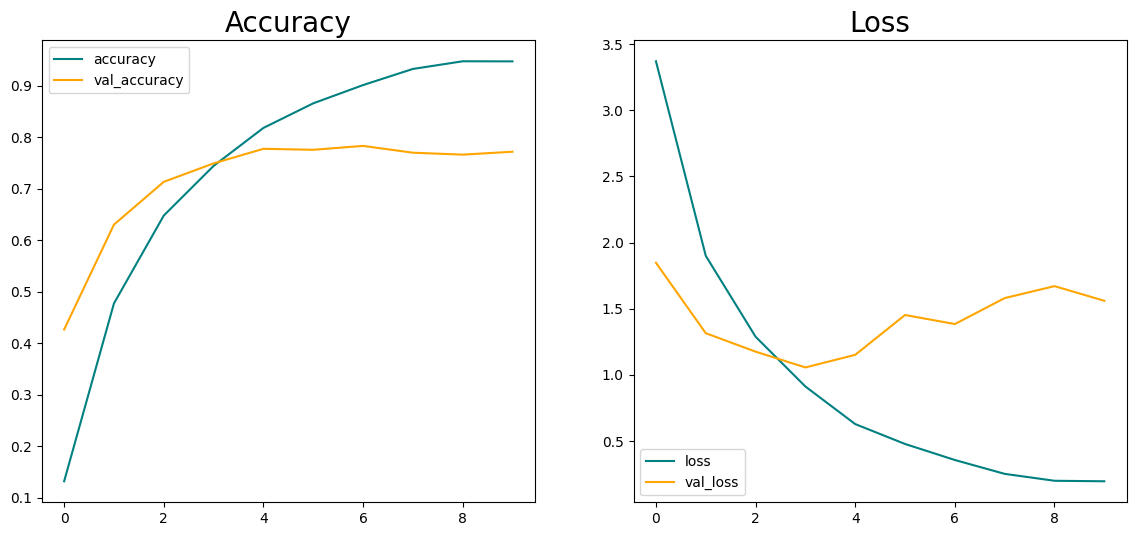

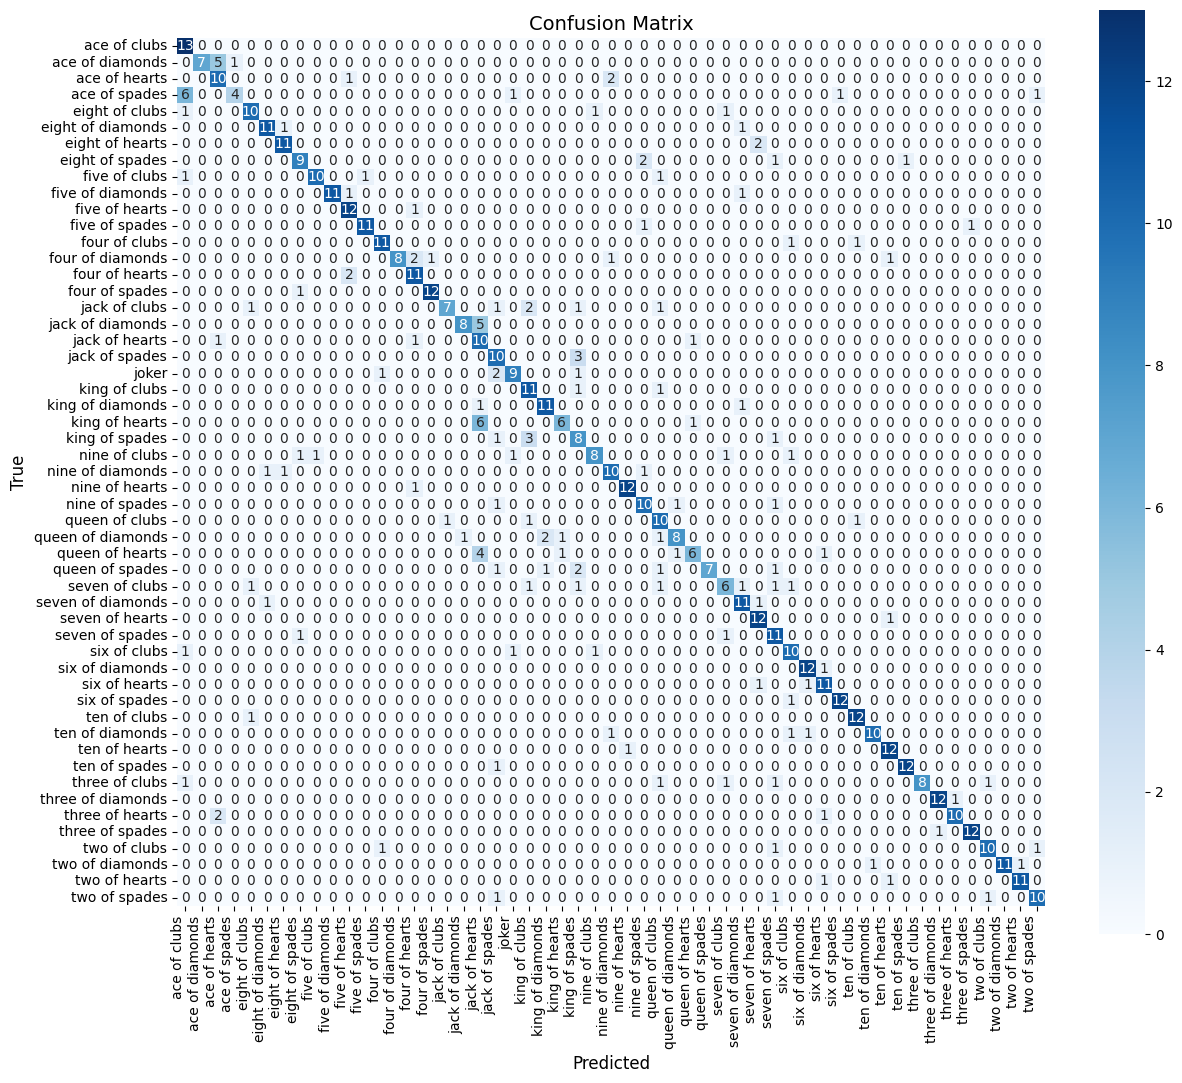

In [ ]:
evaluate_model_with_plots_and_metrics(all_card_model, all_card_hist, normalized_test_pipe)

The graphs above illustrate our model's learning curve regarding playing card features over time. Initially, there's a rapid uptick in accuracy and decline in loss, followed by slower progress. Our model hits a peak of around 90% in training accuracy and 80% in validation accuracy. Meanwhile, the validation set's loss hovers around 1.5 while the training set's loss continues to decrease. Our model may be beginning to overfit the data. This can be seen by the training accuracy continuing to increase (and training loss continue to decrease) while the validation training is staying around the same (and the validation loss may even be slowing increasing). To prevent this issue, we used a callback function to stop training once overfitting is detected. This callback also restores to the weights from the model's training history prior to overfitting happening.

Our model showcases some promising performance metrics: precision of 0.79, recall of 0.76, F1-score of 0.76, and an accuracy of approximately 76%. This suggests its capability to learn card features and make accurate predictions over the test set. However, with only around 10 images per class in the testing/validation sets, our model's evaluation is likely overly optimistic.

Analyzing the confusion matrix, the model successfully identifies most classes correctly, as shown by numerous positions on the diagonal line, indicating accurate positive predictions. However, it struggles to distinguish between Jack of Hearts and King of Hearts cards, showcasing proficiency in suit recognition but difficulty in ranks. Expanding the experiment with a larger and more representative validation/testing set would provide clearer results.

The confusion in our model can possibly be attributed to certain cards, like spades and hearts, appearing as similar shapes. Additionally, the variation in our playing cards means that sometimes the color of the ranks or suits can change, and is not always black or red like it may be in a traditional deck of playing cards.

## Training A Pretrained Model (EfficientNetB0)

We picked EfficientNetB0 for a few reasons. It's a popular CNN architecture for image tasks like classification and object recognition. It stands out due to its abilities for balancing computational efficiency and model performance. It uses something called compound scaling, where it alters the network's width, depth, and image resolution to find the optimal balance between efficiency and accuracy.

Compared to other models like ResNet or AmoebaNet, EfficientNet achieves higher accuracy on ImageNet 1 images while needing fewer parameters. We conjectured that it would be a strong architecture for the task of classifying playing cards.


In [ ]:
base_model = EfficientNetB0(
      include_top=False,
      weights='imagenet',
      input_tensor=None,
      input_shape=(256, 256, 3),
      pooling='avg'
  )

output_layer = tf.keras.layers.Dense(53, activation='softmax')(base_model.output)

efficient_net_model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=output_layer
)

efficient_net_model, efficient_net_hist = compile_and_train_model(efficient_net_model, train_pipe, valid_pipe)

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/100
332/332 [==============================] - 106s 207ms/step - loss: 1.4339 - accuracy: 0.5998 - val_loss: 0.4937 - val_accuracy: 0.8528
Epoch 2/100
332/332 [==============================] - 64s 192ms/step - loss: 0.3999 - accuracy: 0.8828 - val_loss: 0.1980 - val_accuracy: 0.9509
Epoch 3/100
332/332 [==============================] - 64s 191ms/step - loss: 0.2493 - accuracy: 0.9272 - val_loss: 0.2284 - val_accuracy: 0.9340
Epoch 4/100
332/332 [==============================] - 64s 191ms/step - loss: 0.1898 - accuracy: 0.9447 - val_loss: 0.1127 - val_accuracy: 0.9736
Epoch 5/100
332/332 [==============================] - 64s 192ms/step - loss: 0.1506 - accuracy: 0.9560 - val_loss: 0.1001 - val_accuracy: 0.9660
Epoch 6/100
332/332 [==============================] - 64s 192ms/step - loss: 0.1432 - accuracy: 0.9575 - val_loss: 0.0868 - val_accuracy: 0.9774
Epoch 7/100
332/332 [==============================] - 64s

In [ ]:
print('*** PREDICTING ON DATA BATCH ***')
test_data_iterator = test_pipe.as_numpy_iterator()
test_batch = test_data_iterator.next()
display_image_batch_with_predictions(efficient_net_model, test_batch, train_class_mapping_df, 8)

*** PREDICTING ON DATA BATCH ***
1/1 [==============================] - 0s 56ms/step


Precision  Recall      F1 Accuracy
0    0.9694  0.9637  0.9642   0.9637

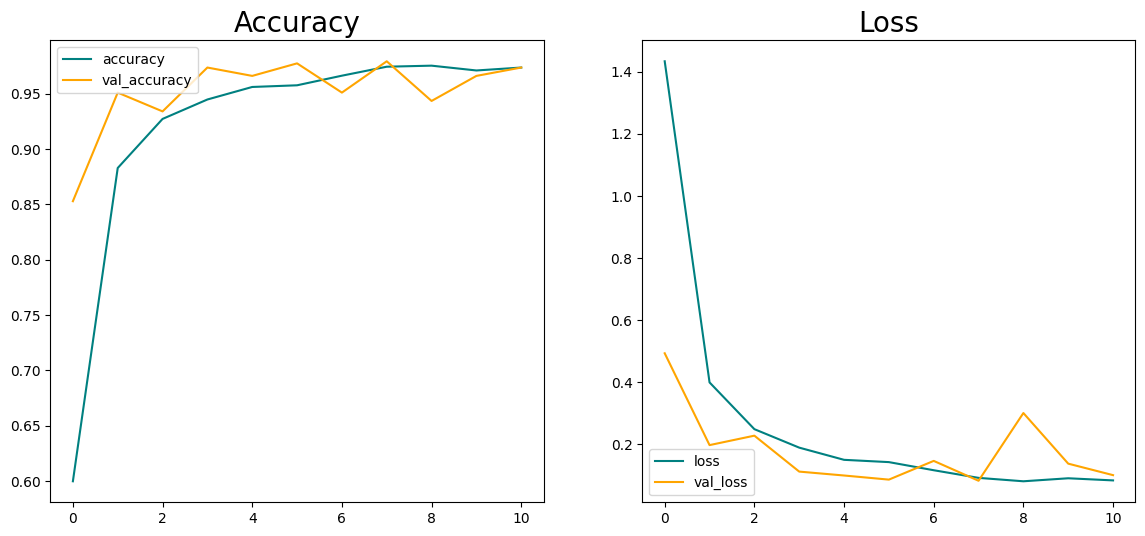

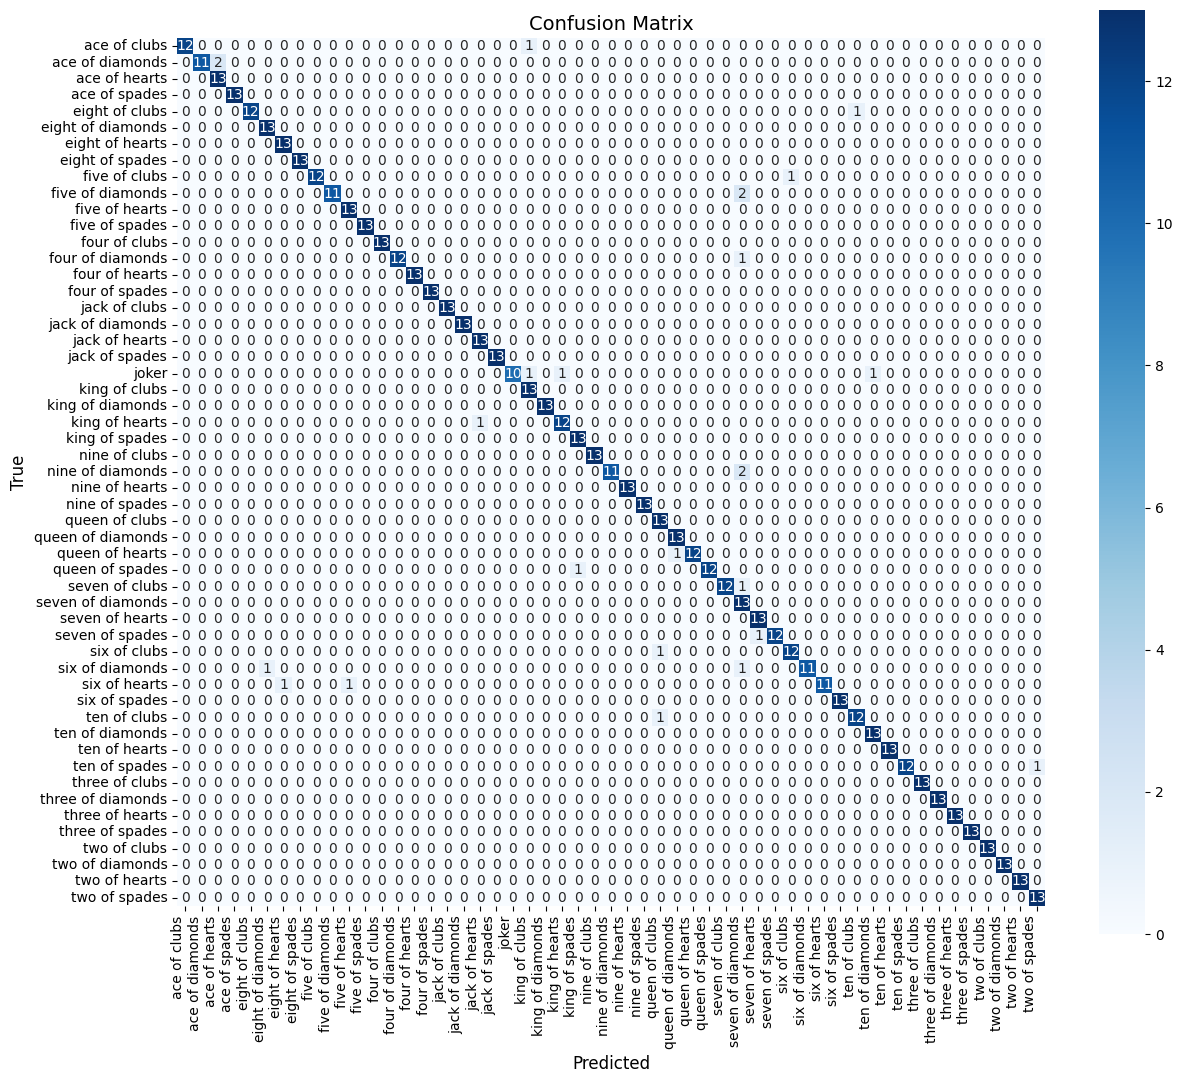

In [ ]:
evaluate_model_with_plots_and_metrics(efficient_net_model, efficient_net_hist, test_pipe)

Similar to our custom CNN, the model sees drastic improvements in accuracy and loss at the beginning, but the progress slows in later epochs. EfficientNetB0's accuracy fluctuates, but the training and validation accuracy remain fairly similar throughout, which indicates the model is not overfitting to the training data. The loss continually decreases as well between the training and validation sets.

EfficientNetB0 achieves some impressive statistics on the test set: ~96% accuracy, with high precision, recall, and F1 score. As expected, it outperforms our custom model, although our custom model is still performing very well (especially considering a random guess would yield ~2% accuracy).

Looking at the confusion matrix, EfficientNetB0 hardly messes up. Whereas, our custom model struggled with distinguishing certain cards like the Jack of Hearts and King of Hearts. Expanding the validation and testing sets could reveal more about its performance, especially if they're more representative of the unique card designs in the dataset.

## Conclusion

Creating our custom model for the classification of card images was an involved process. Neither of us have used neural networks before this class, so it involved research on every aspect of the model. Because this was something we had not done before, we made many mistakes along the way. For example, our first model somehow performed worse than a random guess. We learned the difference between different activation functions and layers and began making small improvements to our model and its hyperparameters, learning a great deal in the process.

Overall, our model achieved ~76% accuracy, whereas the pretrained model was able to achieve ~96% accuracy. The pretrained model also had superior precision, recall, and F1 scores with less confusion between classes as demonstrated by the confusion matrix.

If we were to continue this project in the future, we would begin by investing time in improving the data. It is currently split into training, validation, and test directories, but the splits may not be representative enough of the diverse cards in the data. We would also increase the size of the test and validation sets in this process.

The next step would be taking a deeper dive into layers and options for CNNs. The number of hyperparameters for CNNs is incredible, but this is something we could tune and play with more.

As mentioned in class, there's a multitude of hyperparameters to consider in a neural network. While we considered several of them in the design of our CNN(different activation functions, levels of max-pooling, number of convolutional layers, number of filters in each convolutional layer, etc.), there are always more to consider. It would be interesting and insightful to experiment with more of these hyperparameters in future work, such as different choices of optimizer functions. We could also test a dropout layer if we were to increase the data, further combatting overfitting on our training data. Additionally, we could introduce more trainable parameters to our model. EfficientNetB0 has 11,000,000 trainable parameters, which may help it understand some of the more complex features of our dataset.

Another path we could explore is utilizing sophisticated computer vision tools. If we were able to use computer vision to target the rank and suit of cards successfully, we may be able to achieve improved accuracy by therefore reducing the impact of unique patterns and images on playing card recognition.

We are completing this project with the accomplishment of training a CNN to classify playing cards much more accurately than a random guess. Moreover, we were able to reinforce and apply ideas we have learned in this course. We were able to interpret results, such as accuracy and loss charts, to reason about how our model was performing, noticing when it was overfitting, or when something was working well. As a team, we have shown the ability to approach a data classification problem with machine learning.

## Contributions

### David Riva
--------------------------------------------------------------------------------
- Data preprocessing & normalize data in the pipelines
- Research & import packages for building a deep learning model (CNN)
- Plot the model performance
- Evaluate both of the model's performance across the test set (Accuracy, Precision, Recall, F1-Score, Confusion Matrix, and plots of model accuracy and loss on training/validation set)
- Define a method to predict on a single batch and visualize the images, their labels, and their predictions

### Nathan Orwick
--------------------------------------------------------------------------------
- Load data & establish pipelines
- Split & organize the data into train/valid/test directories
- Train the model (& create dir for logging & fit)
- Add functionality to save the model as a .h5 file
- Research and import a pre-trained model (EfficientNetB0)

### David Riva & Nathan Orwick (Both)
--------------------------------------------------------------------------------
- Establishing GitHub Repo
- Installing dependencies (TensorFlow/OpenCV)
- Redistributing data into train/test/valid to be more fair
- Build the deep learning model (custom CNN)
- Train the pre-trained model


## References

Chng, Z. (2022, June 19). _Using normalization layers to improve deep learning models_. MachineLearningMastery.com. https://machinelearningmastery.com/using-normalization-layers-to-improve-deep-learning-models/#:~:text=Normalization%20can%20help%20training%20of,for%20a%20given%20learning%20rate.

_Convolutional neural network: Benefits, types, and applications_. Datagen. (2023, May 22). https://datagen.tech/guides/computer-vision/cnn-convolutional-neural-network/#:~:text=The%20CNN%20architecture%20is%20especially,and%20produce%20highly%20accurate%20predictions.

_Convolutional Neural Network (CNN)_. TensorFlow. (n.d.). https://www.tensorflow.org/tutorials/images/cnn

Gerry. (2022, November 17). _Cards image dataset-classification_. Kaggle. https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification/

_Keras Documentation: EfficientNet B0 to B7_. Keras. (n.d.-a). https://keras.io/api/applications/efficientnet/

_Keras Documentation: Keras Layers API_. Keras. (n.d.-b). https://keras.io/api/layers/

Potrimba, P. (2023, August 9). _What is EfficientNet? The Ultimate Guide_. Roboflow Blog. https://blog.roboflow.com/what-is-efficientnet/

Sharma, S. (2022, November 20). _Activation functions in neural networks_. Medium. https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6
